In [180]:
import numpy as np
import matplotlib.pyplot as plt
import os
import fitsio
import glob
import pandas as pd

In [136]:
def compute_entropy_1d(x):
    n_steps = len(x)//4 - 1
    proba = {}
    for i in range(n_steps):
        d = x[i*4:(i+1)*4]
        l = list(np.argsort(d))
        l = ''.join(str(e) for e in l)
        try:
            proba[l] += 1
        except:
            proba[l] = 1
    p = np.array(list(proba.values()))
    p = p/p.sum()
    h = np.sum(-p*np.log2(p))/np.log2(24)
    return h

In [211]:
release = 'guadalupe'
fuji_path = "/global/cfs/cdirs/desi/spectro/redux/{}/".format(release)
#data_tiles_fuji = fitsio.read(os.path.join(fuji_path, "tiles-{}.fits".format(release)))
data_tiles_fuji = pd.read_csv(os.path.join(fuji_path, "tiles-{}.csv".format(release)))

In [212]:
#data_tiles_fuji.dtype

In [213]:
def summary_tile_stats(tile_id, last_night):
    n_gal_list = []
    n_star_list = []
    n_qso_list = []
    n_good_z_list = []
    z_entropy = []
    petal_list = [] 
    for petal_id in range(10):
        search_path = "{}/tiles/cumulative/{}/*/redrock-*-{}-thru*.fits".format(fuji_path, tile_id, tile_id)
        #print(search_path)
        try:
            file_in = glob.glob(search_path)[0]
            #print(file_in)
            #print(file_in.split('/')[-1].split('-')[-3])
            this_petal_id = file_in.split('/')[-1].split('-')[-3]
            tile_file = file_in.replace("redrock-{}".format(this_petal_id), "redrock-{}".format(petal_id))
            #tile_file = "{}/tiles/cumulative/{}/{}/redrock-{}-{}-thru{}.fits".format(
            #    fuji_path, tile_id, last_night, petal_id, tile_id, last_night)
            #print(tile_file)
            try:
                z_tile_per_exp = fitsio.read(tile_file, ext="REDSHIFTS")
                fmap_tile_per_exp = fitsio.read(tile_file, ext="FIBERMAP")
                exp_fmap_tile_per_exp = fitsio.read(tile_file, ext="EXP_FIBERMAP")
            except:
                pass
            try:
                ii = (z_tile_per_exp['ZWARN']==0) #& (exp_fmap_tile_per_exp['FIBERSTATUS']==0)
                n_good_z = np.count_nonzero(ii)
                h = compute_entropy_1d(z_tile_per_exp['Z'][ii])
                n_gal = np.count_nonzero(z_tile_per_exp['SPECTYPE'][ii]=='GALAXY')
                n_star = np.count_nonzero(z_tile_per_exp['SPECTYPE'][ii]=='STAR')
                n_qso = np.count_nonzero(z_tile_per_exp['SPECTYPE'][ii]=='QSO')
        
                petal_list.append(petal_id)
                z_entropy.append(h)
                n_gal_list.append(n_gal)
                n_star_list.append(n_star)
                n_qso_list.append(n_qso)
                n_good_z_list.append(n_good_z)
            except:
                pass
        except:
            pass
    return {'petal_id':petal_list, 'z_entropy':z_entropy, 'n_gal':n_gal_list, 'n_star':n_star_list, 'n_qso':n_qso_list, 
           'n_good_z':n_good_z_list}

In [214]:
tile_index = 100
print(data_tiles_fuji['SURVEY'][tile_index])
summary_tile_stats(data_tiles_fuji['TILEID'][tile_index], data_tiles_fuji['LASTNIGHT'][tile_index])

main


{'petal_id': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 'z_entropy': [0.9700677002952041,
  0.9400723720435776,
  0.9501575903328046,
  0.9815422590677778,
  0.9434233787387212,
  0.9688417584195861,
  0.9707597931660142,
  0.9252026044966167,
  0.940938615524604,
  0.9603263307078443],
 'n_gal': [279, 260, 266, 245, 242, 261, 229, 171, 258, 272],
 'n_star': [21, 21, 16, 24, 18, 21, 20, 16, 20, 18],
 'n_qso': [80, 75, 100, 84, 98, 85, 73, 66, 92, 95],
 'n_good_z': [380, 356, 382, 353, 358, 367, 322, 253, 370, 385]}

In [215]:
n_tiles = len(data_tiles_fuji)
print(n_tiles)
h = 'TILEID,PROGRAM,SURVEY,PETALID,H,N_GAL,N_STAR,N_QSO,N_GOOD_Z\n'
out = open('summary_{}.csv'.format(release), 'w')
out.write(h)
for i in range(n_tiles):
    #if data_tiles_fuji['SURVEY'][i]=='main':
    a = summary_tile_stats(data_tiles_fuji['TILEID'][i], data_tiles_fuji['LASTNIGHT'][i])
        #print(a)
    if len(a['petal_id']):
        n_p = len(a['petal_id'])
        for j in range(n_p):
            s = '{},{},{},{},{},{},{},{},{}\n'.format(data_tiles_fuji['TILEID'][i], 
                                                    data_tiles_fuji['FAPRGRM'][i],
                                                    data_tiles_fuji['SURVEY'][i],
                                                 a['petal_id'][j],a['z_entropy'][j],
                                     a['n_gal'][j], a['n_star'][j], a['n_qso'][j], a['n_good_z'][j])
            out.write(s)
out.close()

653


In [216]:
import pandas as pd

In [217]:
release = 'everest'
summary = pd.read_csv("summary_{}.csv".format(release))

(0.88, 1.0)

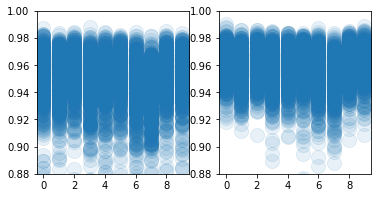

In [218]:
plt.figure(figsize=(6,3))

plt.subplot(1,2,1)
ii=summary['PROGRAM']=='dark'
plt.scatter(summary['PETALID'][ii], summary['H'][ii], alpha=0.1, s=200)
plt.ylim([0.88,1.0])

plt.subplot(1,2,2)
ii=summary['PROGRAM']=='bright'
plt.scatter(summary['PETALID'][ii], summary['H'][ii], alpha=0.1, s=200)
plt.ylim([0.88,1.0])

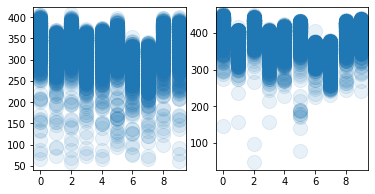

In [219]:
plt.figure(figsize=(6,3))

plt.subplot(1,2,1)
ii=summary['PROGRAM']=='dark'
plt.scatter(summary['PETALID'][ii], summary['N_GOOD_Z'][ii], alpha=0.1, s=200)
#plt.ylim([0.88,1.0])

plt.subplot(1,2,2)
ii=summary['PROGRAM']=='bright'
plt.scatter(summary['PETALID'][ii], summary['N_GOOD_Z'][ii], alpha=0.1, s=200)
#plt.ylim([0.88,1.0])

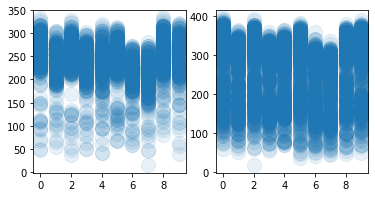

In [220]:
plt.figure(figsize=(6,3))

plt.subplot(1,2,1)
ii=summary['PROGRAM']=='dark'
plt.scatter(summary['PETALID'][ii], summary['N_GAL'][ii], alpha=0.1, s=200)

plt.subplot(1,2,2)
ii=summary['PROGRAM']=='bright'
plt.scatter(summary['PETALID'][ii], summary['N_GAL'][ii], alpha=0.1, s=200)

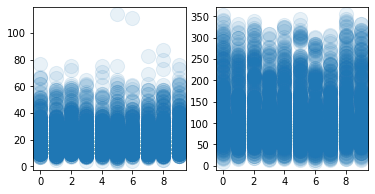

In [221]:
plt.figure(figsize=(6,3))

plt.subplot(1,2,1)
ii=summary['PROGRAM']=='dark'
plt.scatter(summary['PETALID'][ii], summary['N_STAR'][ii], alpha=0.1, s=200)

plt.subplot(1,2,2)
ii=summary['PROGRAM']=='bright'
plt.scatter(summary['PETALID'][ii], summary['N_STAR'][ii], alpha=0.1, s=200)

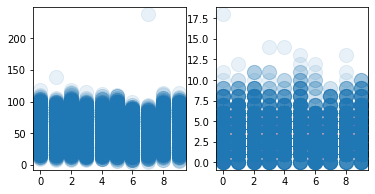

In [222]:
plt.figure(figsize=(6,3))

plt.subplot(1,2,1)
ii=summary['PROGRAM']=='dark'
plt.scatter(summary['PETALID'][ii], summary['N_QSO'][ii], alpha=0.1, s=200)

plt.subplot(1,2,2)
ii=summary['PROGRAM']=='bright'
plt.scatter(summary['PETALID'][ii], summary['N_QSO'][ii], alpha=0.1, s=200)

In [203]:
#[('TARGETID', '>i8'), ('Z', '>f8'), ('ZERR', '>f8'), ('ZWARN', '>i8'), ('CHI2', '>f8'), ('COEFF', '>f8', (10,)), ('NPIXELS', '>i8'), 
# ('SPECTYPE', '<U6'), ('SUBTYPE', '<U20'), ('NCOEFF', '>i8'), ('DELTACHI2', '>f8')])


(0.8, 1.0)

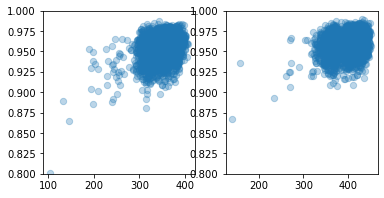

In [204]:
plt.figure(figsize=(6,3))

plt.subplot(1,2,1)
ii=(summary['PROGRAM']=='dark') & (summary['SURVEY']=='main')
plt.scatter(summary['N_GOOD_Z'][ii], summary['H'][ii], alpha=0.3, s=40)
plt.ylim([0.80,1.0])

plt.subplot(1,2,2)
ii=(summary['PROGRAM']=='bright') & (summary['SURVEY']=='main')
plt.scatter(summary['N_GOOD_Z'][ii], summary['H'][ii], alpha=0.3, s=40)
plt.ylim([0.80,1.0])

In [174]:
ii=summary['PROGRAM']=='bright'
mean_h = np.mean(summary['H'][ii])
std_h = np.std(summary['H'][ii])
print(mean_h)

0.9595890478932013


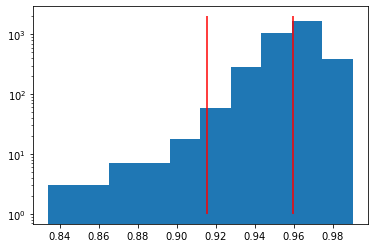

In [175]:
_=plt.hist(summary['H'][ii], log=True)
plt.vlines(mean_h, 1,2000, color='red')
plt.vlines(mean_h-3*std_h, 1,2000, color='red')

In [178]:
lower_h = mean_h - 4*std_h
higher_h = mean_h - 3*std_h
jj = (ii) & (summary['H'] > lower_h) & (summary['H']<higher_h)
print(summary[jj])

      TILEID PROGRAM   SURVEY  PETALID         H  N_GAL  N_STAR  N_QSO  \
346    21169  bright     main        6  0.902918    194      41      0   
584    20575  bright     main        4  0.906820    216      50      3   
829    20004  bright     main        9  0.912436    320      88      4   
1114   20405  bright     main        4  0.912882    267      78      6   
1377   20773  bright     main        7  0.905133    293      47      4   
3196   20094  bright     main        6  0.908407    317      55      3   
3214   21103  bright     main        4  0.915193    323      66      2   
4662   20767  bright     main        2  0.910272    340      71      4   
5147   20780  bright     main        7  0.912709    265      66      4   
5307   21193  bright     main        7  0.906387    276      42      1   
5466   20302  bright     main        6  0.913942    283      83      5   
6091   20831  bright     main        1  0.911922    156      41      1   
6101   20247  bright     main        1

In [177]:
lower_h = mean_h - 4*std_h
higher_h = mean_h - 3*std_h
jj = (ii) & (summary['H'] < lower_h) 
print(summary[jj])

      TILEID PROGRAM   SURVEY  PETALID         H  N_GAL  N_STAR  N_QSO  \
1781   20584  bright     main        1  0.859037    137      17      1   
4345   20411  bright     main        5  0.863103    100      34      2   
6031   22393  bright     main        1  0.879703    117      82      2   
6111   20409  bright     main        1  0.846652    138      55      3   
6131   20760  bright     main        1  0.896723    156      33      7   
6151   20853  bright     main        1  0.890316    138      60      1   
6161   20901  bright     main        1  0.895403    174      24      0   
6201   21272  bright     main        1  0.894200    158      34      5   
6241   20209  bright     main        1  0.893103    144      52      0   
6331   80981  bright  special        1  0.877056    104      17      2   
6332   80981  bright  special        2  0.894654    174      41      5   
6333   80981  bright  special        3  0.866331    132      42      4   
6335   80981  bright  special        5